In [1]:
from json import load
from experiment import Experiment
from dataloaders import *
from train import *

import pickle
import logging
from datetime import datetime

from util import set_seed_everywhere

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Set arguments

args = Config()
args.data = "IMDB"
args.model_name = "DBERT"
args.lr = 2e-5
args.tying = 1
args.l2 = 0
args.conicity = 0
args.batch_size = 32
args.interpreters = ["deeplift", "grad-shap", "deeplift-shap", "int-grad"]
args.correlation_measures = ["kendall-tau", "pearson", "jsd"]
args.repeat = 1
args.gpu = 0
args.pretrained_model = "distilbert-base-uncased"
args.epochs = 5
args.warm_start_size = -1
args.seq_classif_dropout = 0.1
args.clip = 1.0

seeds = [1]

dataloader = dataset_loaders[args.data]

meta = Config()

if args.model_name in TRANSFORMERS:
    tokenizer = DistilBertTokenizer.from_pretrained(args.pretrained_model)
else:
    tokenizer = None

(train, val, test), vocab = dataloader(meta=meta, tokenizer=tokenizer)

In [3]:
# Construct correlation metrics
correlations = [get_corr(key)() for key in args.correlation_measures]

# Initialize logging
fmt = "%Y-%m-%d-%H-%M"
start_time = fname = datetime.now().strftime(fmt)
logging.basicConfig(
    level=logging.INFO,
    handlers=[
        logging.FileHandler(f"log/{args.data}-{args.model_name}-{start_time}.log"),
        logging.StreamHandler(),
    ],
)

args.interpreters = sorted(args.interpreters)
test_lengths = [len(ex.text[1]) for ex in test.examples]
meta_info = {
    "dataset": args.data,
    "model": args.model_name,
    "batch_size": args.batch_size,
    "epochs_per_train": args.epochs,
    "seeds": seeds,
    "interpreters": args.interpreters,
    "correlations": args.correlation_measures,
    "tying": args.tying,
    "conicity": args.conicity,
    "l2": args.l2,
}
logging.info(meta_info)

result_list = []
for i, seed in zip(range(1, args.repeat + 1), seeds):
    logging.info(f"Running experiment {i}/{args.repeat}")
    logging.info(f"=" * 100)

    set_seed_everywhere(seed)
    logging.info(f"Seed = {seed}")
    logging.info(f"Maximum train size: {len(train)}")

    cuda = torch.cuda.is_available() and args.gpu != -1
    device = torch.device("cpu") if not cuda else torch.device(f"cuda:{args.gpu}")

    # Setup the loss fn
    if meta.num_labels == 2:
        # Binary classification
        criterion = nn.BCEWithLogitsLoss()
        meta.num_targets = 1
    else:
        # Multiclass classification
        criterion = nn.CrossEntropyLoss()
        meta.num_targets = meta.num_labels

    experiment = Experiment(train, test, device, args, meta)
    meta_info["test_lengths"] = experiment.test_lengths.tolist()
    meta_info["test_mapping"] = experiment.get_id_mapping()

    results, model = experiment.run(
        create_model_fn=initialize_model,
        criterion=criterion,
        warm_start_size=args.warm_start_size,
        correlations=correlations,
    )
    result_list.append(results)
    

# fname = f"{args.data}-{args.model_name}-conicity={args.conicity}-tying={args.tying}-l2={args.l2}-{start_time}.pkl"
# with open(f"{args.save_dir}/{fname}", "wb") as f:
#     pickle.dump((result_list, meta_info), f)

INFO:root:{'dataset': 'IMDB', 'model': 'DBERT', 'batch_size': 32, 'epochs_per_train': 5, 'seeds': [1], 'interpreters': ['deeplift', 'deeplift-shap', 'grad-shap', 'int-grad'], 'correlations': ['kendall-tau', 'pearson', 'jsd'], 'tying': 1, 'conicity': 0, 'l2': 0}
INFO:root:Running experiment 1/1
INFO:root:====================================================================================================
INFO:root:Seed = 1
INFO:root:Maximum train size: 17212
INFO:root:Training on 17212/17212 labeled data...
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraini

INFO:root:[Train accuracy]: 59.092%


INFO:root:[Test accuracy]: 2705/4363 : 61.999%
INFO:root:[F1]: 0.723
INFO:root:[[ 546 1643]
 [  15 2159]]
INFO:root:Calculating intepretability metrics...
/home/jjukic/.conda/envs/gen/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/jjukic/.conda/envs/gen/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:322: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


INFO:root:Interpretability scores
INFO:root:Calculating cartography...


{'jsd': {('deeplift', 'deeplift-shap'): 0.22014572688126496,
         ('deeplift', 'grad-shap'): 0.29497519147149753,
         ('deeplift', 'int-grad'): 0.2935577430276524,
         ('deeplift-shap', 'grad-shap'): 0.2884341507156221,
         ('deeplift-shap', 'int-grad'): 0.28755268413227975,
         ('grad-shap', 'int-grad'): 0.18321878665670327},
 'kendall_tau': {('deeplift', 'deeplift-shap'): 0.4808751482846726,
                 ('deeplift', 'grad-shap'): 0.2879582068366879,
                 ('deeplift', 'int-grad'): 0.2890018766518628,
                 ('deeplift-shap', 'grad-shap'): 0.31535405575256104,
                 ('deeplift-shap', 'int-grad'): 0.31500537553903424,
                 ('grad-shap', 'int-grad'): 0.5672159707635394},
 'pearson_r': {('deeplift', 'deeplift-shap'): 0.8471544749836735,
               ('deeplift', 'grad-shap'): 0.5932132791419015,
               ('deeplift', 'int-grad'): 0.6039168177675814,
               ('deeplift-shap', 'grad-shap'): 0.6162754578

INFO:root:Training epoch: 2/5


INFO:root:[Train accuracy]: 83.465%


INFO:root:[Test accuracy]: 3788/4363 : 86.821%
INFO:root:[F1]: 0.861
INFO:root:[[2002  187]
 [ 388 1786]]
INFO:root:Calculating intepretability metrics...


INFO:root:Interpretability scores
INFO:root:Calculating cartography...


{'jsd': {('deeplift', 'deeplift-shap'): 0.21067899967646975,
         ('deeplift', 'grad-shap'): 0.2939694690342835,
         ('deeplift', 'int-grad'): 0.2911178269930958,
         ('deeplift-shap', 'grad-shap'): 0.2892811231501059,
         ('deeplift-shap', 'int-grad'): 0.286908587835813,
         ('grad-shap', 'int-grad'): 0.19548261308655254},
 'kendall_tau': {('deeplift', 'deeplift-shap'): 0.4823221611744117,
                 ('deeplift', 'grad-shap'): 0.3077817643859545,
                 ('deeplift', 'int-grad'): 0.30853077303685905,
                 ('deeplift-shap', 'grad-shap'): 0.33267537749322124,
                 ('deeplift-shap', 'int-grad'): 0.33243723497923,
                 ('grad-shap', 'int-grad'): 0.5122033326434908},
 'pearson_r': {('deeplift', 'deeplift-shap'): 0.9265709367324457,
               ('deeplift', 'grad-shap'): 0.8197972700492198,
               ('deeplift', 'int-grad'): 0.8375164124729926,
               ('deeplift-shap', 'grad-shap'): 0.830328090933995

INFO:root:Training epoch: 3/5


INFO:root:[Train accuracy]: 89.327%


INFO:root:[Test accuracy]: 3837/4363 : 87.944%
INFO:root:[F1]: 0.877
INFO:root:[[1967  222]
 [ 304 1870]]
INFO:root:Calculating intepretability metrics...


INFO:root:Interpretability scores
INFO:root:Calculating cartography...


{'jsd': {('deeplift', 'deeplift-shap'): 0.28455635783105926,
         ('deeplift', 'grad-shap'): 0.35522573817250847,
         ('deeplift', 'int-grad'): 0.35389533356335967,
         ('deeplift-shap', 'grad-shap'): 0.34390153507236354,
         ('deeplift-shap', 'int-grad'): 0.34219658634547845,
         ('grad-shap', 'int-grad'): 0.23750428438798127},
 'kendall_tau': {('deeplift', 'deeplift-shap'): 0.4175374657244918,
                 ('deeplift', 'grad-shap'): 0.25492392039834455,
                 ('deeplift', 'int-grad'): 0.25844962514760633,
                 ('deeplift-shap', 'grad-shap'): 0.2728909640293236,
                 ('deeplift-shap', 'int-grad'): 0.2747964654013279,
                 ('grad-shap', 'int-grad'): 0.43450258260772495},
 'pearson_r': {('deeplift', 'deeplift-shap'): 0.7972215229885139,
               ('deeplift', 'grad-shap'): 0.6171426432213253,
               ('deeplift', 'int-grad'): 0.624673720382019,
               ('deeplift-shap', 'grad-shap'): 0.64670463

INFO:root:Training epoch: 4/5


INFO:root:[Train accuracy]: 92.941%


INFO:root:[Test accuracy]: 3801/4363 : 87.119%
INFO:root:[F1]: 0.878
INFO:root:[[1783  406]
 [ 156 2018]]
INFO:root:Calculating intepretability metrics...


INFO:root:Interpretability scores
INFO:root:Calculating cartography...


{'jsd': {('deeplift', 'deeplift-shap'): 0.30246711262775394,
         ('deeplift', 'grad-shap'): 0.38648509619045335,
         ('deeplift', 'int-grad'): 0.3892202964747438,
         ('deeplift-shap', 'grad-shap'): 0.3777392732614694,
         ('deeplift-shap', 'int-grad'): 0.38080604831188625,
         ('grad-shap', 'int-grad'): 0.25207969864342206},
 'kendall_tau': {('deeplift', 'deeplift-shap'): 0.3996044094729315,
                 ('deeplift', 'grad-shap'): 0.2073821206053311,
                 ('deeplift', 'int-grad'): 0.20305897434857967,
                 ('deeplift-shap', 'grad-shap'): 0.217636659101302,
                 ('deeplift-shap', 'int-grad'): 0.21090415070781532,
                 ('grad-shap', 'int-grad'): 0.4035507907801087},
 'pearson_r': {('deeplift', 'deeplift-shap'): 0.7490517593531251,
               ('deeplift', 'grad-shap'): 0.49691624196451173,
               ('deeplift', 'int-grad'): 0.4910723403847296,
               ('deeplift-shap', 'grad-shap'): 0.5231247670

INFO:root:Training epoch: 5/5


INFO:root:[Train accuracy]: 95.335%


INFO:root:[Test accuracy]: 3808/4363 : 87.279%
INFO:root:[F1]: 0.874
INFO:root:[[1885  304]
 [ 251 1923]]
INFO:root:Calculating intepretability metrics...


INFO:root:Interpretability scores
INFO:root:Calculating cartography...


{'jsd': {('deeplift', 'deeplift-shap'): 0.3143727347507529,
         ('deeplift', 'grad-shap'): 0.4038225989890117,
         ('deeplift', 'int-grad'): 0.40953783007192496,
         ('deeplift-shap', 'grad-shap'): 0.3954846679809119,
         ('deeplift-shap', 'int-grad'): 0.4006464624781549,
         ('grad-shap', 'int-grad'): 0.2626779614442524},
 'kendall_tau': {('deeplift', 'deeplift-shap'): 0.3846725537352335,
                 ('deeplift', 'grad-shap'): 0.16599527201969091,
                 ('deeplift', 'int-grad'): 0.15233275920490752,
                 ('deeplift-shap', 'grad-shap'): 0.1747178449496898,
                 ('deeplift-shap', 'int-grad'): 0.16217815483264567,
                 ('grad-shap', 'int-grad'): 0.37973686482973157},
 'pearson_r': {('deeplift', 'deeplift-shap'): 0.7033623365603818,
               ('deeplift', 'grad-shap'): 0.39219585752825736,
               ('deeplift', 'int-grad'): 0.3746676478158296,
               ('deeplift-shap', 'grad-shap'): 0.4246492148

INFO:root:Saving the model...
INFO:root:Computing dataset cartography...


In [4]:
def calc_entropy(input_tensor):
    lsm = nn.LogSoftmax(dim=1)
    log_probs = lsm(input_tensor)
    probs = torch.exp(log_probs)
    p_log_p = log_probs * probs
    entropy = -p_log_p.mean(dim=1)
    return entropy

In [5]:
# Saliency distribution statistics

model.train()
grads = []
vars_ = []
kurts = []
skews = []
enc = []
norms = []

for b in make_iterable(test, device=device):
    inputs, lengths = b.text
    inputs.requires_grad = False
    pad_idx = model.vocab.get_padding_index()
    attention_mask = inputs != pad_idx  # Orig impl was .long()
    embedded_tokens = model.embeddings(inputs)
    embedded_tokens = torch.autograd.Variable(embedded_tokens, requires_grad=True)
    head_mask = attention_mask.unsqueeze(0).unsqueeze(2).unsqueeze(-1)
    head_mask = head_mask.expand(
        model.encoder.n_layers, -1, model.encoder.n_heads, -1, attention_mask.shape[1]
    )
    encoded = model.encoder(
        inputs_embeds=embedded_tokens,
        head_mask=head_mask,
        attention_mask=attention_mask,
    )[0][:, 0]
    
    enc.append(encoded.cpu())
    
    mean = encoded.mean()
    mean.backward()
    enc_grad = embedded_tokens.grad.data
    norm = enc_grad.norm(p=2, dim=-1)
    grads.append(enc_grad.norm(p=2, dim=(1,2)))
    mean = torch.mean(norm, 1)
    mean = mean.repeat_interleave(norm.shape[1]).reshape(-1, norm.shape[1])

    diffs = norm - mean

    var = torch.mean(torch.pow(diffs, 2.0), 1)
    vars_.append(var)
    std = torch.pow(var, 0.5)
    std = std.repeat_interleave(diffs.shape[1]).reshape(-1, diffs.shape[1])
    zscores = diffs / std
    skew = torch.mean(torch.pow(zscores, 3.0), 1)
    skews.append(skew)
    kurtosis = torch.mean(torch.pow(zscores, 4.0), 1) - 3.0
    kurts.append(kurtosis)
    norms.append(norm)

grad = torch.cat(grads).cpu()
var = torch.cat(vars_).cpu()
skew = torch.cat(skews).cpu()
kurt = torch.cat(kurts).cpu()
enc = torch.cat(enc).cpu()
dist = torch.cdist(enc, enc)

In [6]:
for i in range(len(dist)):
    dist[i][i] = np.inf
    
min_dist = dist.min(1).values.detach()

In [7]:
for i in range(len(dist)):
    dist[i][i] = 0
    
mean_dist = dist.mean(1).detach()

In [8]:
from scipy.stats import pearsonr, kendalltau

conf = results["cartography"]["test"]["confidence"]
variab = results["cartography"]["test"]["variability"]
tc = conf*(1-conf)

print("Confidence")
print(f"Min dist: {pearsonr(min_dist, conf)}")
print(f"Mean dist: {pearsonr(mean_dist, conf)}")
print(f"Grad norm: {pearsonr(grad, conf)}")
print(f"Var: {pearsonr(var, conf)}")
print(f"Skew: {pearsonr(skew, conf)}")
print(f"Kurtosis: {pearsonr(kurt, conf)}")
print("="*100)
print("Threshold closeness")
print(f"Min dist: {pearsonr(min_dist, tc)}")
print(f"Mean dist: {pearsonr(mean_dist, tc)}")
print(f"Grad norm: {pearsonr(grad, tc)}")
print(f"Var: {pearsonr(var, tc)}")
print(f"Skew: {pearsonr(skew, tc)}")
print(f"Kurtosis: {pearsonr(kurt, tc)}")
print("="*100)
print("Variability")
print(f"Min dist: {pearsonr(min_dist, variab)}")
print(f"Mean dist: {pearsonr(mean_dist, variab)}")
print(f"Grad norm: {pearsonr(grad, variab)}")
print(f"Var: {pearsonr(var, variab)}")
print(f"Skew: {pearsonr(skew, variab)}")
print(f"Kurtosis: {pearsonr(kurt, variab)}")

Confidence
Min dist: (0.4974251843663135, 1.5607343862291275e-271)
Mean dist: (0.4941234192739808, 2.0271138980482984e-267)
Grad norm: (-0.1111132252179599, 1.8382793622764209e-13)
Var: (0.009475117797410774, 0.5315151756787395)
Skew: (0.14804852323031084, 8.323372500701085e-23)
Kurtosis: (0.13974796036987636, 1.7985323983862297e-20)
Threshold closeness
Min dist: (-0.7443031411111576, 0.0)
Mean dist: (-0.7210888727434978, 0.0)
Grad norm: (0.17346502644695286, 8.082479597529688e-31)
Var: (-0.010353669857839793, 0.4941561526610633)
Skew: (-0.22306932934168305, 2.4969149067228434e-50)
Kurtosis: (-0.21430178699797467, 1.6922893596789506e-46)
Variability
Min dist: (0.04305012966558808, 0.00445378651054)
Mean dist: (0.08569290069196522, 1.4356461399928635e-08)
Grad norm: (0.29936974821055784, 4.871780331785587e-91)
Var: (0.004573399332509245, 0.7626506852648985)
Skew: (-0.3356138925356771, 2.4589953960716207e-115)
Kurtosis: (-0.3344713899899211, 1.6176636018048833e-114)


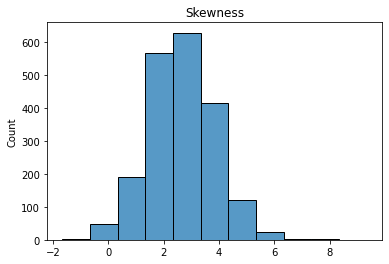

In [70]:
sns.histplot(skew)
plt.title("Skewness");

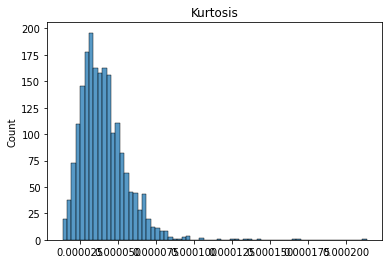

In [92]:
sns.histplot(norm)
plt.title("Kurtosis");

In [ ]:
# model.train()
# ents = []
# norms = []

# for b in make_iterable(test, device=device):
#     inputs, lengths = b.text
#     inputs.requires_grad = False
#     pad_idx = model.vocab.get_padding_index()
#     attention_mask = inputs != pad_idx  # Orig impl was .long()
#     embedded_tokens = model.embeddings(inputs)
#     embedded_tokens = torch.autograd.Variable(embedded_tokens, requires_grad=True)
#     head_mask = attention_mask.unsqueeze(0).unsqueeze(2).unsqueeze(-1)
#     head_mask = head_mask.expand(
#         model.encoder.n_layers, -1, model.encoder.n_heads, -1, attention_mask.shape[1]
#     )
#     encoded = model.encoder(
#         inputs_embeds=embedded_tokens,
#         head_mask=head_mask,
#         attention_mask=attention_mask,
#     )[0][:, 0]
#     mean = encoded.mean()
#     mean.backward()
#     enc_grad = embedded_tokens.grad.data
#     norm = enc_grad.norm(p=2, dim=(1,2))
#     norms.append(norm)
#     print(norm)
# #     entropy = calc_entropy(norm*1e7)
# #     ents.append(entropy)
# norm = torch.cat(norms).cpu().numpy()

In [235]:
model.train()
device = torch.device("cpu")
model.to(device)
enc = []

for b in make_iterable(test, device=device):
    inputs, lengths = b.text
    inputs.requires_grad = False
    pad_idx = model.vocab.get_padding_index()
    attention_mask = inputs != pad_idx  # Orig impl was .long()
    embedded_tokens = model.embeddings(inputs)
    embedded_tokens = torch.autograd.Variable(embedded_tokens, requires_grad=True)
    head_mask = attention_mask.unsqueeze(0).unsqueeze(2).unsqueeze(-1)
    head_mask = head_mask.expand(
        model.encoder.n_layers, -1, model.encoder.n_heads, -1, attention_mask.shape[1]
    )
    encoded = model.encoder(
        inputs_embeds=embedded_tokens,
        head_mask=head_mask,
        attention_mask=attention_mask,
    )[0][:, 0]
    
    enc.append(encoded.cpu())
    
enc = torch.cat(enc)
pd = torch.nn.PairwiseDistance()
dist = torch.cdist(enc, enc)

In [236]:
dist.shape

torch.Size([2000, 2000])

In [243]:
ex_dist = dist.mean(1).detach().numpy()

/home/jjukic/.conda/envs/gen/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:ylabel='Count'>

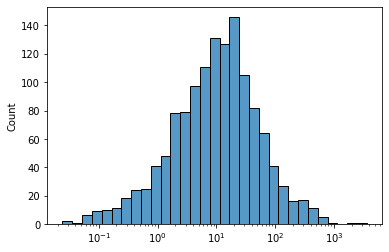

In [119]:

vari = results["cartography"]["test"]["variability"]

NameError: name 'conf' is not defined

(-0.3502921003702205, 8.09742682386112e-59)

<AxesSubplot:ylabel='Count'>

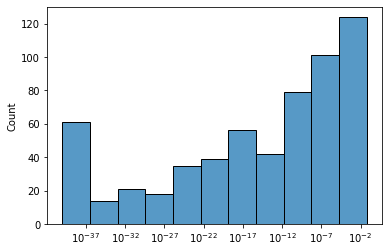

In [193]:
inds = conf > 0.9
norm_easy = ent[inds]
conf_easy = conf[inds]

sns.histplot(norm_easy+1e-40, log_scale=True)

<AxesSubplot:ylabel='Count'>

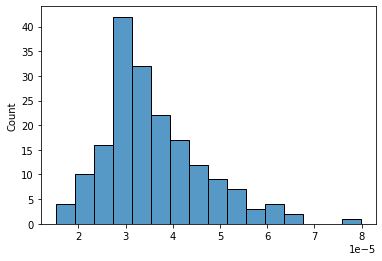

In [82]:
inds = conf < 0.5
norm_easy = norm[inds]
conf_easy = conf[inds]

sns.histplot(norm_easy)

<AxesSubplot:ylabel='Count'>

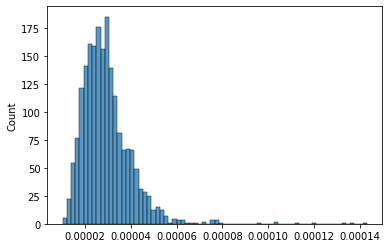

In [78]:
import seaborn as sns


sns.histplot(norm)

In [27]:
import scipy.stats as stats
import numpy as np

# Interesting story, wonderful and exiciting acting, and very impressive dialogue. 
X = np.array([1, 0.04, 1.1, 0.01, 1.4, 0.02, 0.05, 1.2, 1.3, 0.03])
Y = np.array([1.4, 0.02, 1.3, 0.01, 1, 0.03, 0.04, 1.1, 1.2, 0.05])

print(stats.kendalltau(X, Y))
print(stats.pearsonr(X, Y))

KendalltauResult(correlation=0.4666666666666666, pvalue=0.07255015432098766)
(0.9459306038458809, 3.502055879128291e-05)


In [35]:
from sklearn.preprocessing import MinMaxScaler as MMS

mms = MMS((0, 1))
x_t = mms.fit_transform(X.reshape(-1, 1)).ravel()
y_t = mms.fit_transform(Y.reshape(-1, 1)).ravel()

In [2]:
import scipy.stats as stats
import numpy as np

In [3]:
stats.kendalltau([1,2], [2,1])

KendalltauResult(correlation=-1.0, pvalue=1.0)

In [38]:
y_t

array([1.        , 0.00719424, 0.92805755, 0.        , 0.71223022,
       0.01438849, 0.02158273, 0.78417266, 0.85611511, 0.02877698])

In [36]:
print(stats.kendalltau(x_t, y_t))
print(stats.pearsonr(x_t, y_t))

KendalltauResult(correlation=0.4666666666666666, pvalue=0.07255015432098766)
(0.945930603845881, 3.5020558791282634e-05)


In [ ]:
import scipy.stats as stats

# Interesting story, wonderful and exiciting acting, and very impressive dialogue. 
X = [1, 0.03, 1.1, 0.01, 1.4, 0.02, 0.05, 1.2, 1.3, 0.04]
Y = [1.4, 0.02, 1.3, 0.01, 1.1, 0.03, 0.05, 1, 1.1, 0.04]

print(stats.kendalltau(X, Y))
print(stats.pearsonr(X, Y))